In [1]:
import numpy as np 
import pandas as pd
from pandas import datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

# Load the dataset
df = pd.read_csv("../input/amazon-stocks-lifetime-dataset/AMZN.csv", index_col=0, parse_dates=[0], date_parser=parser)

In [3]:
# Show first 5 rows
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [4]:
# Statistic summary of the dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5665.000000,5665.000000,5665.000000,5665.000000,5665.000000,5.665000e+03
mean,315.126044,318.499003,311.288491,315.053306,315.053306,7.602816e+06
std,488.289599,492.442904,483.041434,487.953106,487.953106,7.369511e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.150002,37.980000,36.500000,37.150002,37.150002,3.712600e+06
50%,80.110001,81.949997,78.010002,79.937500,79.937500,5.721800e+06
75%,320.989990,324.130005,316.750000,322.200012,322.200012,8.641200e+06
max,2038.109985,2050.500000,2013.000000,2039.510010,2039.510010,1.043292e+08


In [5]:
# Keep only 'Close' column
amzn = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
amzn = amzn[amzn.index >= '2015-01-01']

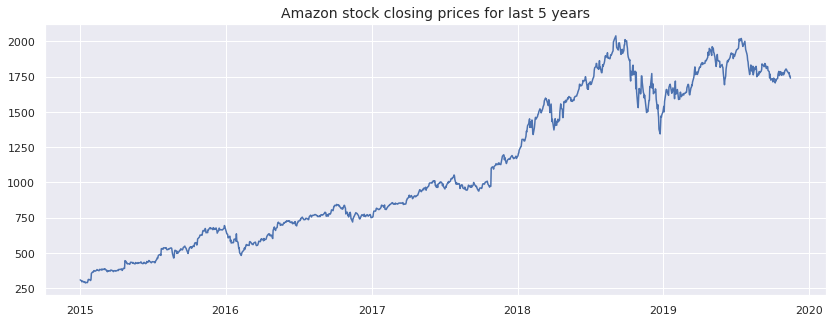

In [6]:
plt.figure(figsize=(14, 5))
plt.title('Amazon stock closing prices for last 5 years', fontsize=14)
plt.plot(amzn.Close)

# Stationary Series ?

**Statistical properties such as the mean and variance is not constant over a time hence it is a non-stationary series.**

In [7]:
Q1_2019_mean = amzn[(amzn.index >= '2019-01-01') & (amzn.index < '2019-03-31')].mean()
Q1_2019_var  = amzn[(amzn.index >= '2019-01-01') & (amzn.index < '2019-03-31')].var()
Q1_2017_mean = amzn[(amzn.index >= '2017-01-01') & (amzn.index < '2017-03-31')].mean()
Q1_2017_var  = amzn[(amzn.index >= '2017-01-01') & (amzn.index < '2017-03-31')].var()
Q4_2015_mean = amzn[(amzn.index >= '2015-10-01') & (amzn.index < '2015-12-31')].mean()
Q4_2015_var  = amzn[(amzn.index >= '2015-10-01') & (amzn.index < '2015-12-31')].var()

print('2019 Quarter 1 closing price mean     : %.2f ' % (Q1_2019_mean))
print('2019 Quarter 1 closing price variance : %.2f ' % (Q1_2019_var))
print("---------------------------------------------- ")
print('2017 Quarter 1 closing price mean     : %.2f ' % (Q1_2017_mean))
print('2017 Quarter 1 closing price variance : %.2f ' % (Q1_2017_var))
print("---------------------------------------------- ")
print('2015 Quarter 4 closing price mean     : %.2f ' % (Q4_2015_mean))
print('2015 Quarter 4 closing price variance : %.2f ' % (Q4_2015_var))

2019 Quarter 1 closing price mean     : 1664.34 
2019 Quarter 1 closing price variance : 3961.09 
---------------------------------------------- 
2017 Quarter 1 closing price mean     : 832.63 
2017 Quarter 1 closing price variance : 630.34 
---------------------------------------------- 
2015 Quarter 4 closing price mean     : 629.68 
2015 Quarter 4 closing price variance : 2663.21 


**Plot the autocorrelation function (ACF). The ACF value decreases very slowely for non-stationary series.**

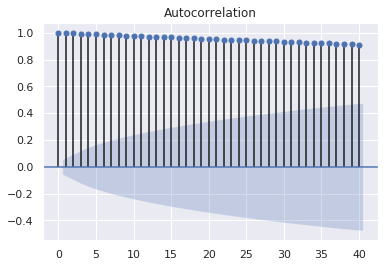

In [8]:
plot_acf(amzn, lags=40)
plt.show()

# Convert series into Stationary series.

In [9]:
# Calculate the differnce of a element compared with a prevous row element
amzn_diff = amzn.diff(periods=1)
# Drop rows with NAN value. First row element will have NAN value because there is no previous element for calculating the differnce.
amzn_diff = amzn_diff.dropna()
# Display first five rows
amzn_diff.head()

,Close
Date,
2015-01-05,-6.329987
2015-01-06,-6.899993
2015-01-07,3.130004
2015-01-08,2.039978
2015-01-09,-3.529998


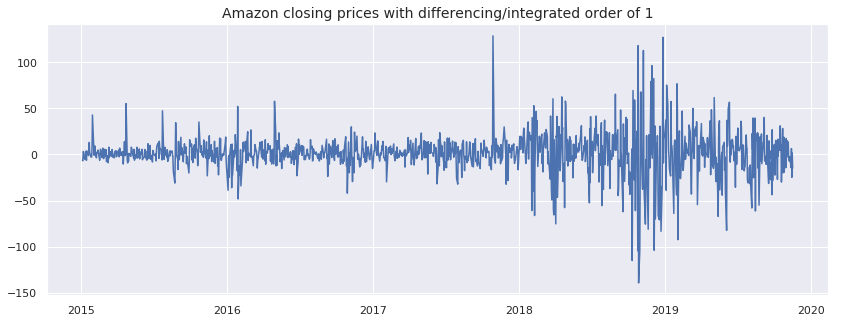

In [10]:
plt.figure(figsize=(14,5))
plt.title("Amazon closing prices with differencing/integrated order of 1",fontsize=14)
plt.plot(amzn_diff)

**Plot the autocorrelation function. The ACF value decreases to zero quickly for stationary series.**

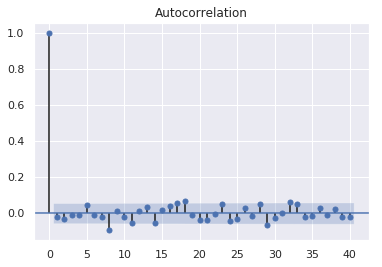

In [11]:
plot_acf(amzn_diff, lags=40)
plt.show()

# Autoregression Model

In [12]:
X = amzn.values
size = int(len(X) * 0.70)  # 70 % 
# Training set
train = X[:size]
# testing set
test  = X[size:len(X)]

print("Total Samples    : %d" % len(X))
print("Training Samples : %d" % len(train))
print("Testing Samples  : %d" % len(test))

Total Samples    : 1228
Training Samples : 859
Testing Samples  : 369


In [13]:
# train autoregression
ar_model = AR(train)
ar_model_fit = ar_model.fit()
print("Lags : %s" % ar_model_fit.k_ar)
print("Coefficients : %s" % ar_model_fit.params)

Lags : 21
Coefficients : [ 0.15011193  1.00034063 -0.01930613 -0.02891179  0.0065099   0.04891829
  0.02663261 -0.020074   -0.07619803  0.09928654 -0.0362198   0.00598414
 -0.02752875 -0.04766673  0.07538306 -0.00427602  0.03571702  0.01186344
 -0.04222053  0.02852493 -0.04093789  0.00594584]


AR MModel Mean Squared Error : 436643.25


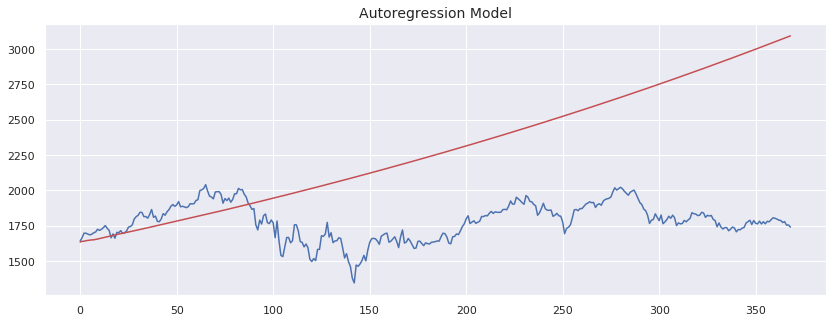

In [14]:
# make predictions
preds = ar_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print("AR MModel Mean Squared Error : %.2f" % mean_squared_error(test, preds))
plt.figure(figsize=(14,5))
plt.title("Autoregression Model",fontsize=14)
plt.plot(test)
plt.plot(preds, color='r')

# Autoregressive Integrated Moving Average ARIMA(p,d,q) Model

In [15]:
stock_history = [x for x in train ]
preds = []

# order=(p,d,q)
p = 5   # AR parameters/Lags
q = 1    # Differencing order
d = 0    # MA parameters

#arima_model = ARIMA(train, order=(5,1,0))
#arima_model_fit = arima_model.fit()

for i in range(len(test)):
    # initiate ARIMA model
    arima_model = ARIMA(stock_history, order=(p,q,d))
    # fit ARIMA mode;
    arima_model_fit = arima_model.fit()
    # forecast price
    output = arima_model_fit.forecast()[0]
    # append the test price to a stock history data
    stock_history.append(test[i])  
    # append the forcasted price to a list
    preds.append(output)

Mean Squared Error : 1137.65


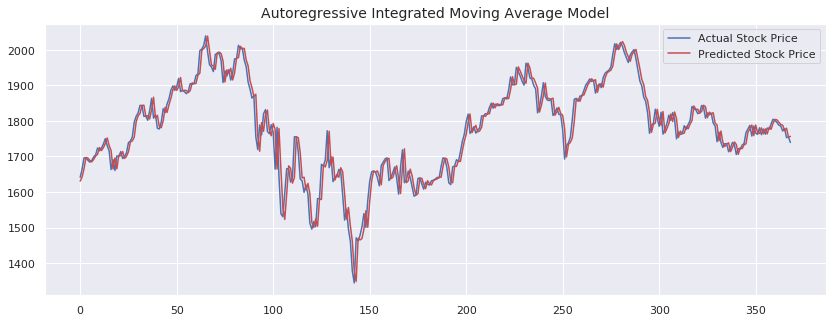

In [16]:
print("Mean Squared Error : %.2f" % mean_squared_error(test, preds))
plt.figure(figsize=(14,5))
plt.title("Autoregressive Integrated Moving Average Model",fontsize=14)
plt.plot(test, label='Actual Stock Price')
plt.plot(preds, color='r', label='Predicted Stock Price')
plt.legend()

# Forecasting Stock Prices for next 300 days

In [17]:
train_test = np.concatenate((train, test))
stock_history = [x for x in train_test]
preds = []
forecasting_days = 300

for i in range(forecasting_days):
    # initiate ARIMA model
    arima_model = ARIMA(stock_history, order=(p,q,d))
    # fit ARIMA mode;
    arima_model_fit = arima_model.fit()
    # forecast price
    output = arima_model_fit.forecast()[0]
    # append the forecasted price to a stock history data
    stock_history.append(output)  
    # append the forcasted price to a prediction list
    preds.append(output)

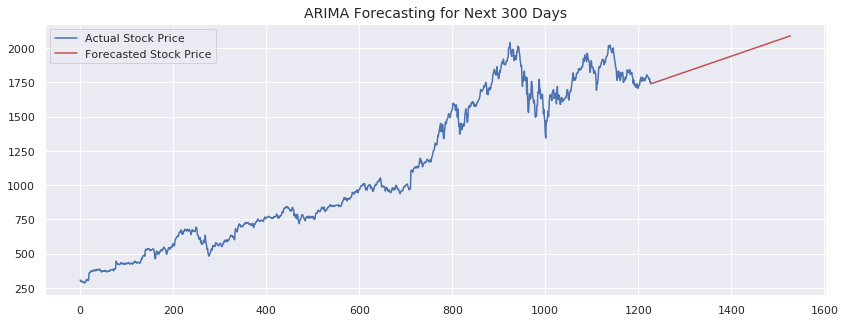

In [18]:
start = len(train_test)
end = len(train_test) + int(forecasting_days)
history = pd.Series(stock_history)

plt.figure(figsize=(14,5))
plt.title("ARIMA Forecasting for Next 300 Days",fontsize=14)
plt.plot(history[0:start], label='Actual Stock Price')
plt.plot(history[start:end], color='r', label='Forecasted Stock Price')
plt.legend()